# Overlapping Mixtures of Gaussian Processses

*Valentine Svensson 2015 <br> (with small edits by James Hensman November 2015) 
converted to GPflow by Daniel Marthaler September 2016*

This illustrates use of the OMGP model described in

**Overlapping Mixtures of Gaussian Processes for the data association problem**  
_Miguel Lázaro-Gredilla, Steven Van Vaerenbergh, Neil D. Lawrence_  
Pattern Recognition 2012

The GPclust implementation makes use of the collapsed variational mixture model for GP assignment.

In [1]:
%matplotlib inline
import numpy as np
import GPflow
from GPclust import OMGP
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12,6)
from matplotlib import pyplot as plt

## Diverging trend seperation

One application of the OMGP model could be to find diverging trends among populations over time. Imagine for example two species evolving from a common ancestor over time.

We load some pre-generated data which diverge over time.

In [2]:
XY = np.loadtxt('../data/split_data_test.csv', delimiter=',', skiprows=1, usecols=[1, 2])
X = XY[:, 0, None]
Y = XY[:, 1, None]

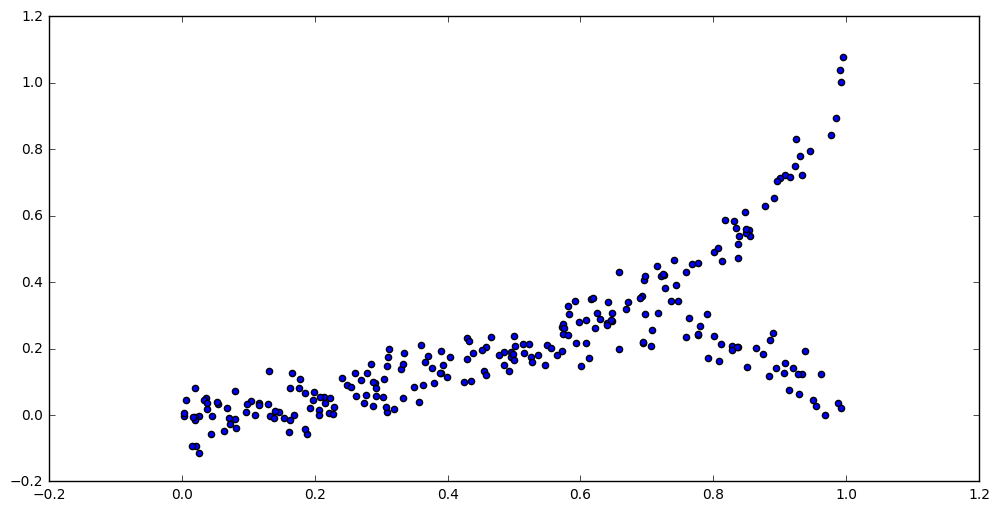

In [3]:
plt.scatter(X, Y);

We define a model assuming `num_clusters` = 2 trends. By default the model will be populated by `num_clusters` RBF kernels. The OMGP implementation is compatible with most kernels in GPflow, so that you for example can encode periodicity in the model.

In [4]:
m = OMGP(X, Y, num_clusters=2, noise_variance=0.01, prior_Z='DP')
m.log_likelihood()

1177.8703211977181

A simple plot function is included which illustrates the asignment probability for each data point, it also shows the posterior mean and confidence intervals for each Gaussian Process.

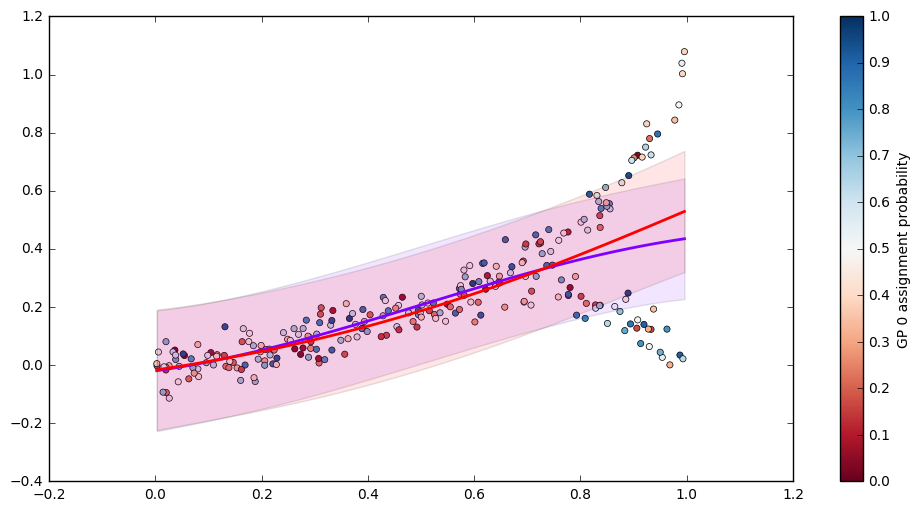

In [5]:
from plotter import OMGPplot
OMGPplot(m,X,Y)

There is also a function for plotting the assignment probability for a given GP directly. Since we haven't optimized the mixture parameters yet the assignment probability is just a random draw from the prior.

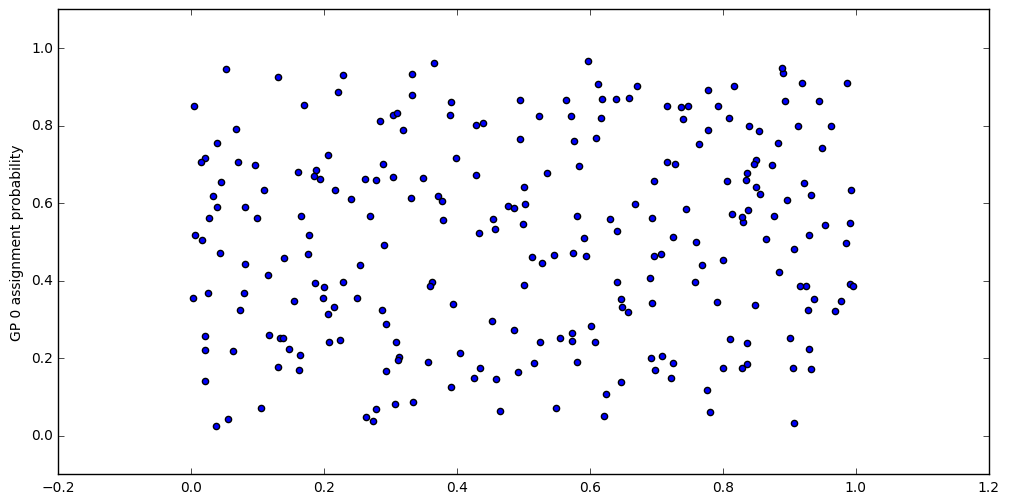

In [6]:
from plotter import OMGPplot_probs
OMGPplot_probs(m, X, gp_num=0)

We can first performa a quick optimization to find the rough trends.

In [7]:
m.optimize(step_length=0.01, maxiter=20)

iteration 1 bound=1181.63163276 grad=376.896210697, beta=0
iteration 2 bound=1188.8680566 grad=351.529924121, beta=1.00160314121
iteration 3 bound=1199.01259468 grad=307.847402954, beta=0.998371979394
iteration 4 bound=1211.13091325 grad=254.411733023, beta=0.984751402047
iteration 5 bound=1223.80379186 grad=197.921958106, beta=0.955272839543
iteration 6 bound=1235.27657727 grad=143.678266897, beta=0.907942789927
iteration 7 bound=1244.14797034 grad=96.7929865533, beta=0.848711868943
iteration 8 bound=1250.0672507 grad=61.2601749354, beta=0.790536805639
iteration 9 bound=1253.60096438 grad=37.7432467692, beta=0.744380783445
iteration 10 bound=1255.57947773 grad=23.7631763244, beta=0.712928678638
iteration 11 bound=1256.67115805 grad=15.9655676155, beta=0.694363528497
iteration 12 bound=1257.29785865 grad=11.6829529844, beta=0.688727546216
iteration 13 bound=1257.69302442 grad=9.23699423708, beta=0.699046514384
iteration 14 bound=1257.97540944 grad=7.70136851473, beta=0.725825551882
ite

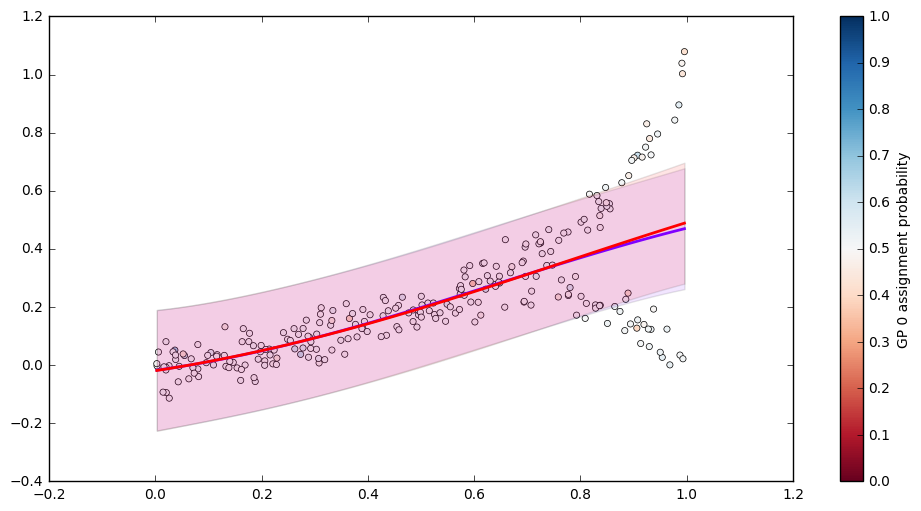

In [8]:
OMGPplot(m,X,Y)

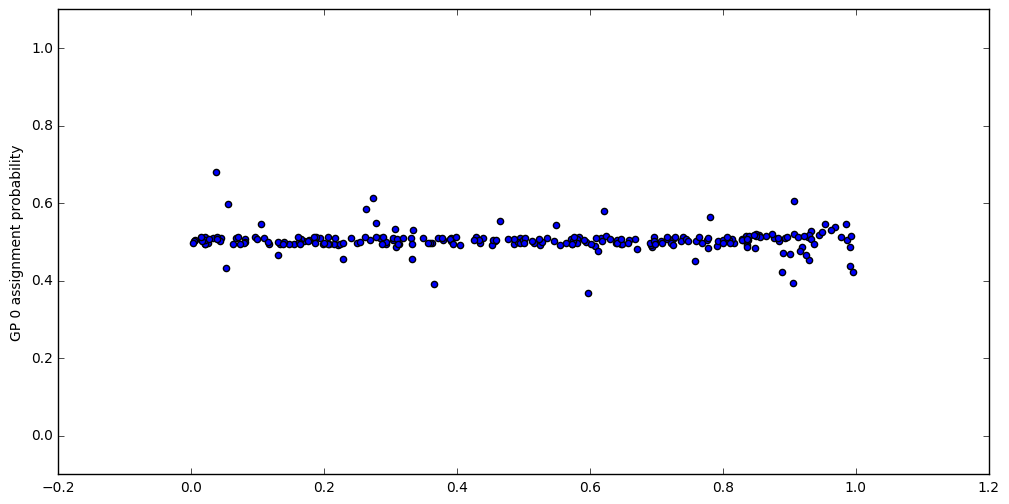

In [9]:
OMGPplot_probs(m,X)

The model identifies the branches of the time series, and in particular the non-branched region have ambigous GP assignment. In this region the two trends share information for prediction.

Like any GPy model the hyper parameters can be inspected.

In [11]:
m

Name,values,prior,constraint
model.noise_variance,[ 0.01],None,+ve
model.kern.item0.lengthscales,[ 1.],None,+ve
model.kern.item0.variance,[ 1.],None,+ve
model.kern.item1.variance,[ 1.],None,+ve
model.kern.item1.lengthscales,[ 1.],None,+ve


We continue by letting the model optimize some more, and also allow it to optimize the hyper parameters. The hyper parameter optimization works best if the mixture parameters have converged or are close to converging.

In [12]:
m.optimize(step_length=0.01, maxiter=200)

iteration 1 bound=1259.04729632 grad=2.56657988452, beta=0
iteration 2 bound=1259.09579333 grad=2.46794645093, beta=0.981438475996
iteration 3 bound=1259.16249268 grad=2.27999957665, beta=0.962643781634
iteration 4 bound=1259.24079226 grad=2.0218576721, beta=0.94348343486
iteration 5 bound=1259.3234111 grad=1.71939718499, beta=0.9238585557
iteration 6 bound=1259.40352689 grad=1.40106092816, beta=0.903767437553
iteration 7 bound=1259.47573889 grad=1.09339165157, beta=0.883302247066
iteration 8 bound=1259.53664519 grad=0.817280690621, beta=0.862628154018
iteration 9 bound=1259.58493945 grad=0.585746116532, beta=0.841950217633
iteration 10 bound=1259.62108201 grad=0.403596529331, beta=0.821481289213
iteration 11 bound=1259.64671596 grad=0.268756622045, beta=0.801425999131
iteration 12 bound=1259.66403433 grad=0.174580967514, beta=0.781993617102
iteration 13 bound=1259.67526067 grad=0.112345606391, beta=0.763450444749
iteration 14 bound=1259.68232038 grad=0.0732823600409, beta=0.7462260954

In [14]:
m

Name,values,prior,constraint
model.noise_variance,[ 1.00000000e-06],None,+ve
model.kern.item0.lengthscales,[ 6.9200905],None,+ve
model.kern.item0.variance,[ 4.02786486],None,+ve
model.kern.item1.variance,[ 0.00992454],None,+ve
model.kern.item1.lengthscales,[ 0.07086671],None,+ve


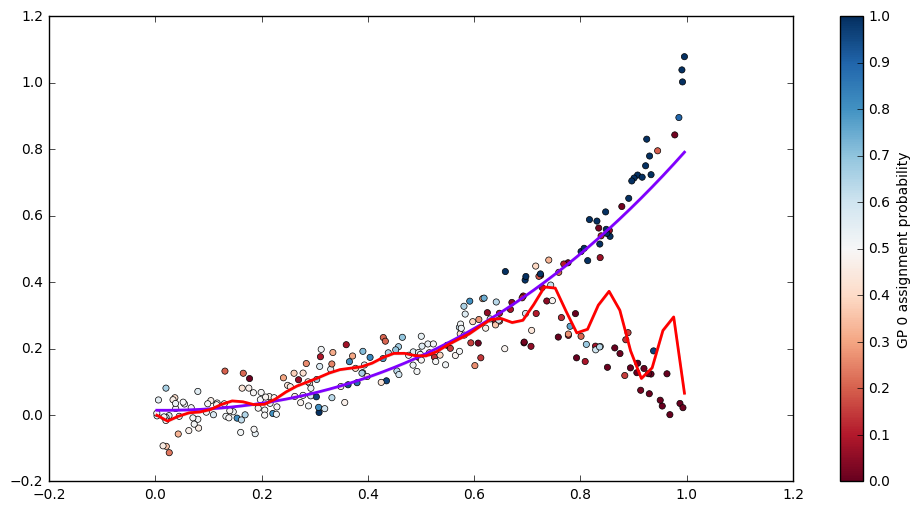

In [15]:
OMGPplot(m,X,Y)

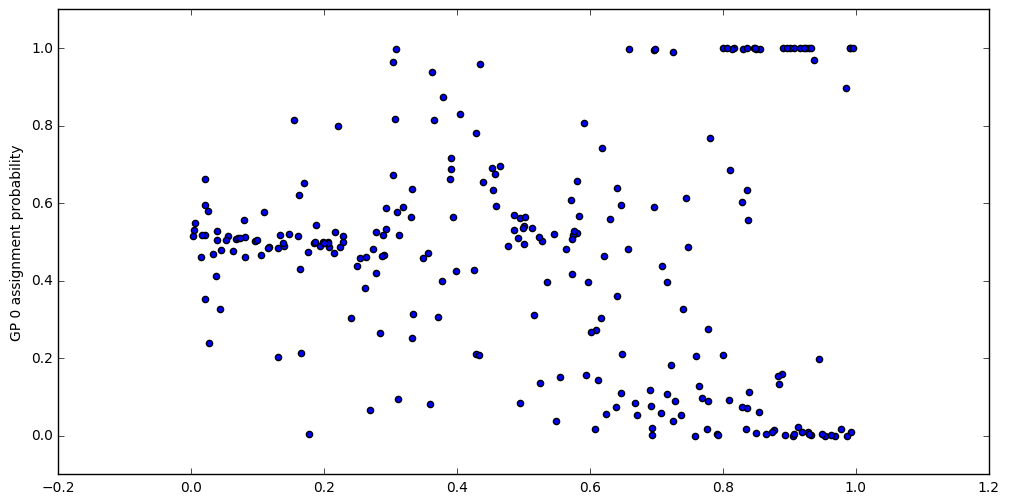

In [16]:
OMGPplot_probs(m,X)

## Separating signal from noise

An interesting application of the OMGP model pointed out in the original publication is the use for robust GP regression.

Let's illustrate this by creating sinusoidal test data with background noise.

In [17]:
x1 = np.random.uniform(0, 10, (100, 1))
x2 = np.random.uniform(0, 10, (100, 1))

y1 = 4 * np.random.randn(*x1.shape)
y2 = 3 * np.sin(x2) + 0.5 * np.random.randn(*x2.shape)
x = np.vstack((x1, x2))
y = np.vstack((y1, y2))

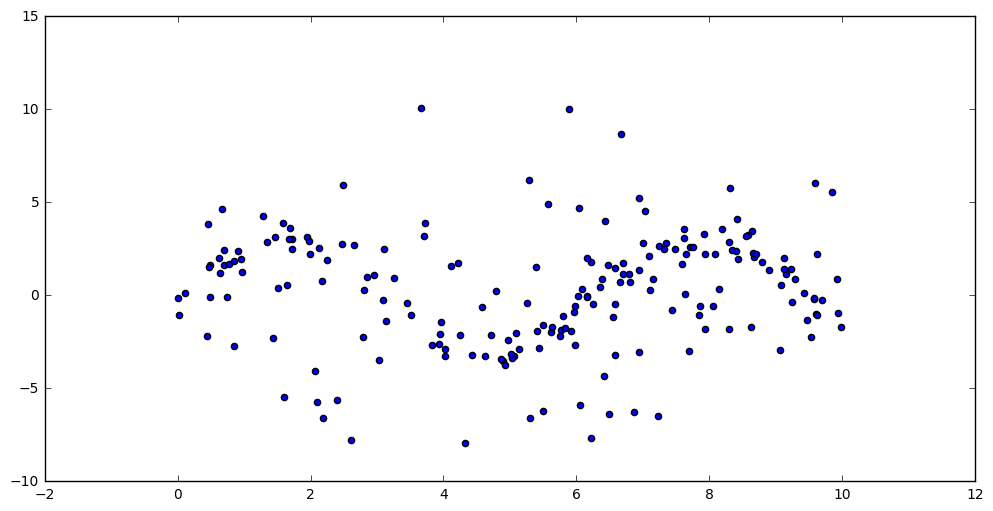

In [18]:
plt.scatter(x, y);

First we make a model with only one mixture component / kernel. This is equivalent to normal GP regression.

In [19]:
kernels = [GPflow.kernels.RBF(1,lengthscales=2.0)]
m = OMGP(x, y, num_clusters=1, prior_Z='DP', kernels=kernels, noise_variance=3.)
m.hyperparam_interval = 100

In [22]:
m.optimize(verbose=False)

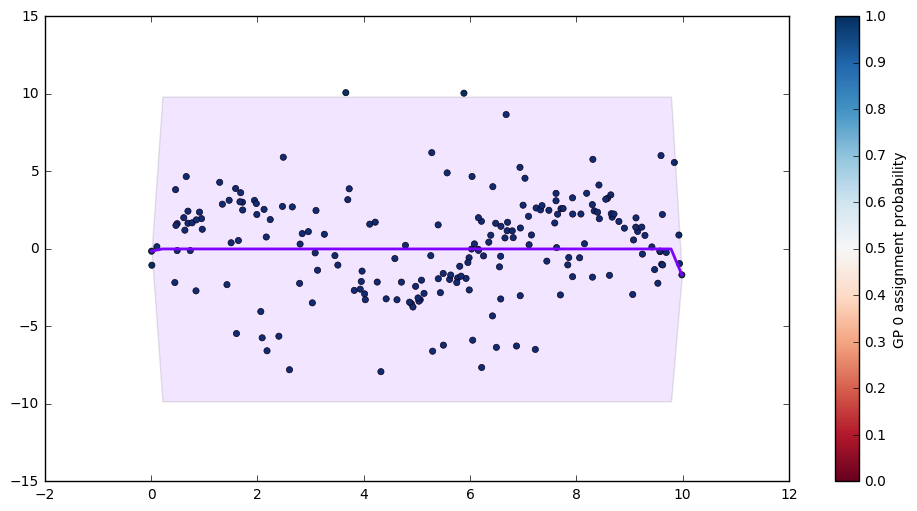

In [23]:
OMGPplot(m,x,y)

Now we in stead view this is a mixture problem, and consider two _different_ kinds of kernels for the different GP components. One encoding white noise, and another which can encode a trend over time (an RBF kernel in this case).

In [24]:
kernels = [GPflow.kernels.White(1), GPflow.kernels.RBF(1, lengthscales=2.0)]
m = OMGP(x, y, num_clusters=2, prior_Z='DP', kernels=kernels, noise_variance=3.)
m.hyperparam_interval = 250

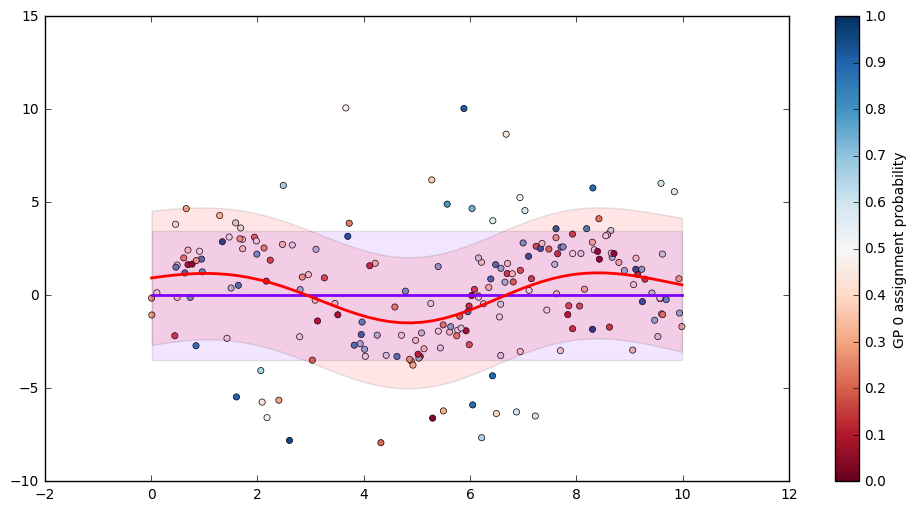

In [25]:
OMGPplot(m,x,y)

In [26]:
m.optimize(step_length=0.01, verbose=False)

In [27]:
m

Name,values,prior,constraint
model.kern.item0.variance,[ 19.74407605],None,+ve
model.kern.item1.variance,[ 171.53066409],None,+ve
model.kern.item1.lengthscales,[ 1.38624301],None,+ve
model.noise_variance,[ 0.22278826],None,+ve


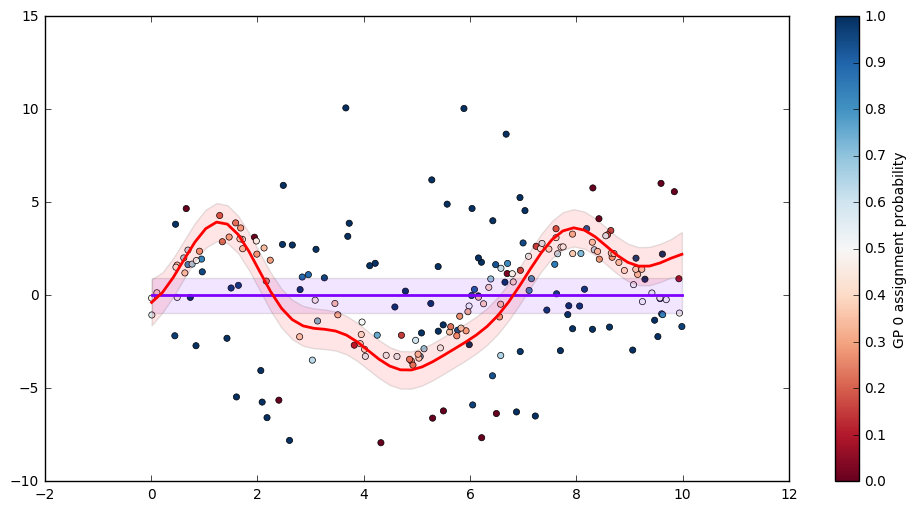

In [28]:
OMGPplot(m,x,y)

The trend over time is much more noticable, and the confidence intervals are smaller.

Noisy points will have high assignment probability to the 'noise GP', while the assignment of the sinusoidal points is ambiguous. We can use this to seperate the points which are more likely to be noise from the remaining points.

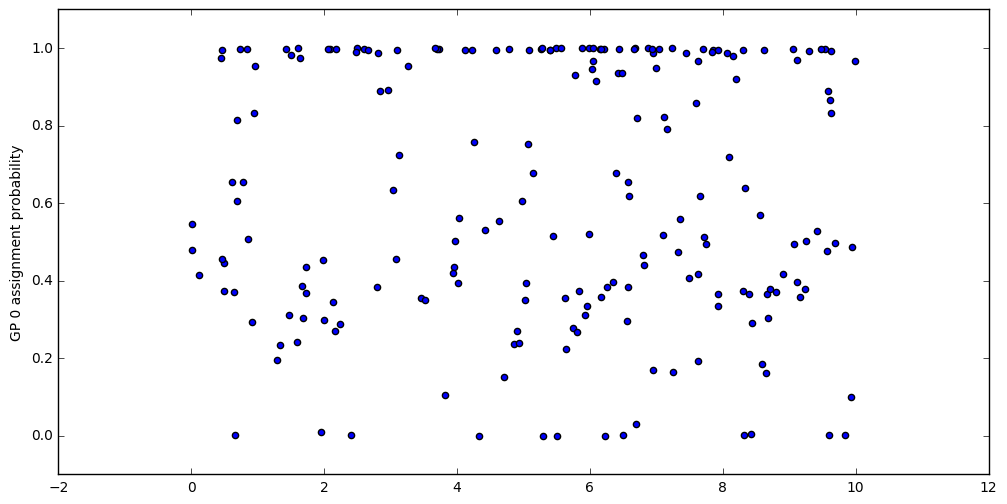

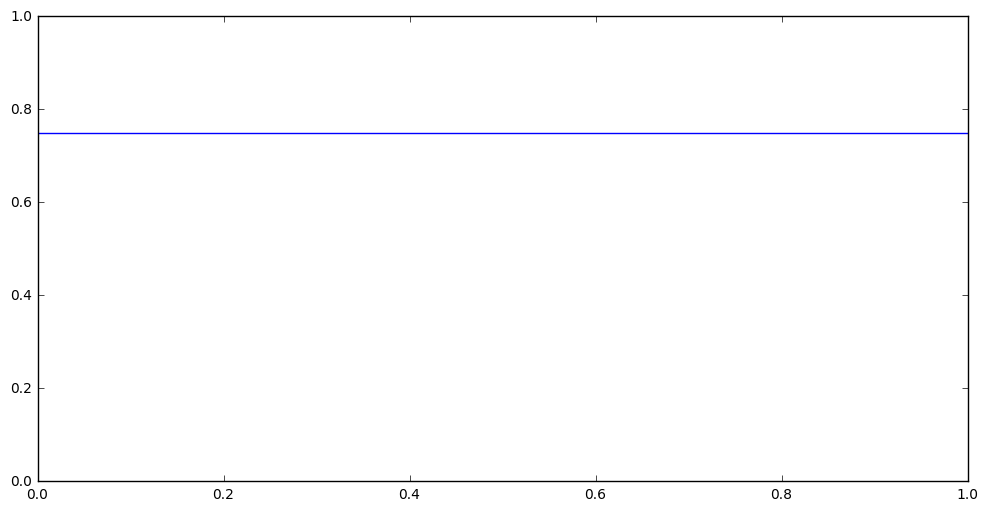

In [29]:
OMGPplot_probs(m,x)
plt.axhline(0.75);

In [30]:
thr = 0.75
phi = m.get_phi()
idx = np.where(phi[:,0] < thr)[0]
nidx = np.where(phi[:,0] >= thr)[0]

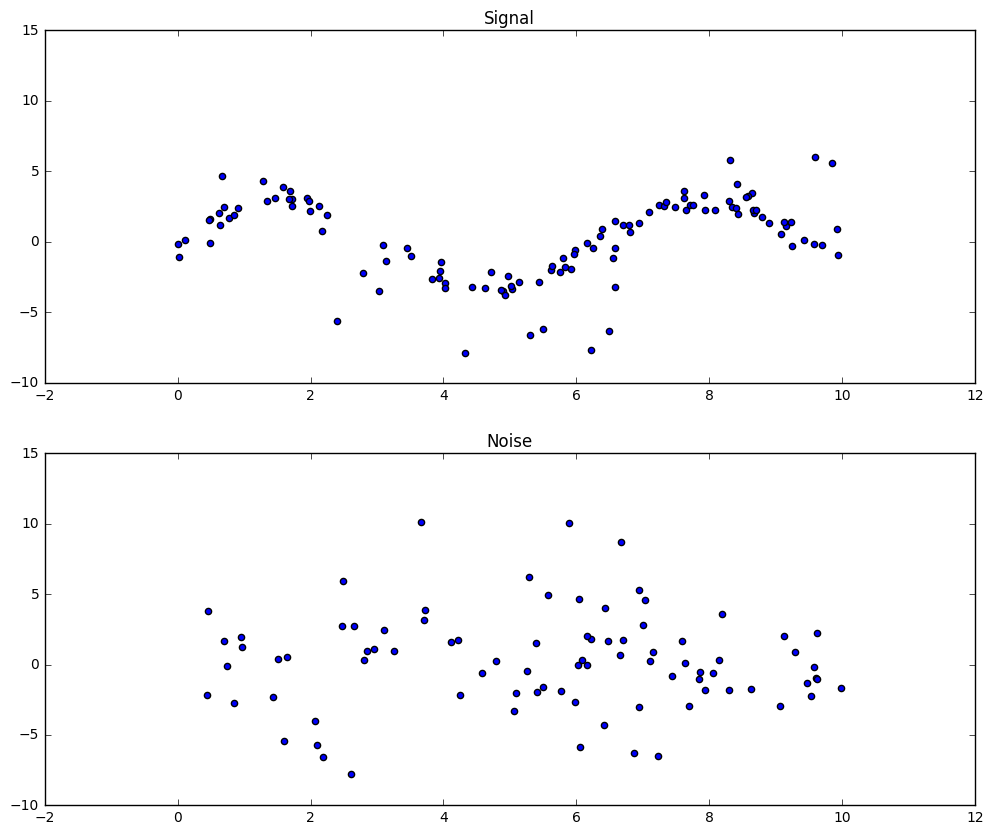

In [31]:
plt.figure(figsize=(12,10))
plt.subplot(211)
plt.scatter(x[idx], y[idx]);
plt.title('Signal')

plt.subplot(212, sharey=plt.gca())
plt.scatter(x[nidx], y[nidx]);
plt.title('Noise');